In [2]:
import arviz as az
import matplotlib as mpl
import matplotlib.pyplot as plt
import missingno as mno
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
from IPython.display import display
from patsy import dmatrix

# az.style.use("arviz-darkgrid")
sns.set_theme()
az.rcParams["stats.hdi_prob"] = 0.89

In [3]:
def standardize(array, reference=None, use_std=True):
    if reference is None:
        reference = array
    return (array - reference.mean()) / (reference.std() if use_std else 1)

In [4]:
kung = pd.read_csv("data/Howell1.csv", sep=";")
kung.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='weight', ylabel='height'>

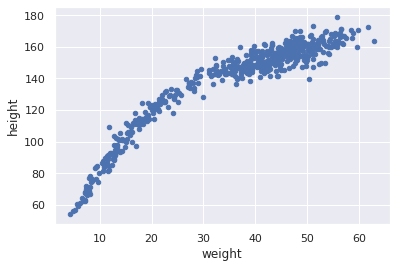

In [5]:
kung.plot("weight", "height", kind="scatter")

In [6]:
kids = kung[kung.age < 18][["weight", "height", "age"]]
kids[kids.weight > 30]

,weight,height,age
80,41.900561,147.955,17.0
108,32.460178,148.590,16.0
143,38.130078,149.225,17.0
185,32.205032,142.875,17.0
219,44.735511,147.955,16.0
239,40.766581,153.670,16.0
256,43.091240,158.115,17.0
270,35.493574,145.415,15.0
289,33.792604,147.955,17.0
297,34.841535,143.510,16.0


# 2.1

In [7]:
adults = kung[kung.age >= 18].copy()
adults["weight_s"] = standardize(adults.weight)
adults.describe()

,height,weight,age,male,weight_s
count,352.000000,352.000000,352.000000,352.000000,3.520000e+02
mean,154.597093,44.990486,41.138494,0.468750,1.211152e-16
std,7.742332,6.456708,15.967855,0.499733,1.000000e+00
min,136.525000,31.071052,18.000000,0.000000,-2.155810e+00
25%,148.590000,40.256290,28.000000,0.000000,-7.332212e-01
50%,154.305000,44.792210,39.000000,0.000000,-3.070845e-02
75%,160.655000,49.292693,51.000000,1.000000,6.663160e-01
max,179.070000,62.992589,88.000000,1.000000,2.788124e+00


In [8]:
adults.head()

,height,weight,age,male,weight_s
0,151.765,47.825606,63.0,1,0.439097
1,139.700,36.485807,63.0,0,-1.317185
2,136.525,31.864838,65.0,0,-2.032870
3,156.845,53.041915,41.0,1,1.246987
4,145.415,41.276872,51.0,0,-0.575156


In [9]:
with pm.Model() as m_adult:
    weight_s = pm.Data("weight_s", adults.weight_s.values)
    a = pm.Normal("α", mu=155, sd=20)
    b = pm.Lognormal("β", mu=0, sd=1)
    mu = pm.Deterministic("μ", a + b * weight_s)
    sigma = pm.Uniform("σ", 0, 50)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=adults.height)
    trace_adult = pm.sample()

/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


[Text(0.5, 0, 'weight'), Text(0, 0.5, 'height')]

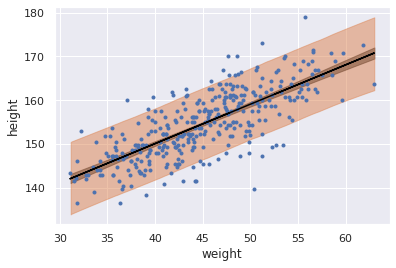

In [10]:
height_pred = pm.fast_sample_posterior_predictive(trace_adult, model=m_adult)["height"]
fig, ax = plt.subplots()
ax.plot(adults.weight, adults.height, ".")
ax.plot(adults.weight, trace_adult.μ.mean(axis=0), color="black")
az.plot_hdi(adults.weight, trace_adult.μ, ax=ax, color="black")
az.plot_hdi(adults.weight, height_pred, ax=ax)
ax.set(xlabel="weight", ylabel="height")

In [11]:
missing_weights = np.array([45, 40, 65, 31, 53])
with m_adult:
    pm.set_data({"weight_s": standardize(missing_weights, adults.weight)})
    height_pred_data = pm.fast_sample_posterior_predictive(trace_adult)["height"]

In [12]:
missing_df = pd.DataFrame(missing_weights, columns=["weight"])
missing_df["expected_height"] = height_pred_data.mean(axis=0)
missing_df[["hdi_lower", "hdi_upper"]] = az.hdi(height_pred_data)
missing_df

/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


,weight,expected_height,hdi_lower,hdi_upper
0,45,154.548795,146.747237,162.701653
1,40,150.225469,141.715531,157.944203
2,65,172.423816,164.396342,181.011893
3,31,141.935706,134.157248,150.770623
4,53,161.722471,153.657963,169.945444


# 2.2

In [13]:
kung["weight_s"] = standardize(kung.weight)
kung["log_weight"] = np.log(kung.weight)
kung["log_weight_s"] = standardize(kung.log_weight)
kung["log_height"] = np.log(kung.height)
kung.head()

,height,weight,age,male,weight_s,log_weight,log_weight_s,log_height
0,151.765,47.825606,63.0,1,0.829869,3.867561,0.738301,5.022333
1,139.700,36.485807,63.0,0,0.059459,3.596923,0.268410,4.939497
2,136.525,31.864838,65.0,0,-0.254483,3.461503,0.033289,4.916508
3,156.845,53.041915,41.0,1,1.184257,3.971082,0.918038,5.055258
4,145.415,41.276872,51.0,0,0.384957,3.720302,0.482625,4.979592


In [14]:
with pm.Model() as m_log:
    a = pm.Normal("α", mu=155, sd=20)
    b = pm.Lognormal("β", mu=0, sd=1)
    mu = pm.Deterministic("μ", a + b * kung.log_weight_s)
    sigma = pm.Uniform("σ", 0, 50)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=kung.height)
    trace_log = pm.sample()

/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


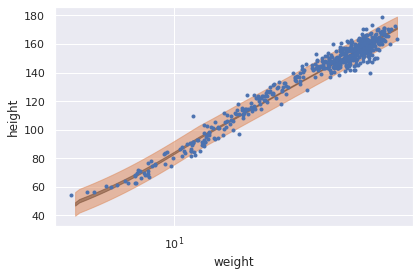

In [15]:
height_pred = pm.fast_sample_posterior_predictive(trace_log, model=m_log)["height"]

fig, ax = plt.subplots()
ax.semilogx(kung.weight, kung.height, ".")
az.plot_hdi(kung.weight, trace_log.μ, ax=ax, color="black")
az.plot_hdi(kung.weight, height_pred, ax=ax)
ax.set(xlabel="weight", ylabel="height")
fig.tight_layout()

In [16]:
trace_log.α.mean(), trace_log.β.mean()

(138.2667585040793, 27.110694189315804)

## Bonus

Weight is proportional to the cube of the height.

In [17]:
weights_m = np.vstack(
    (
        kung.weight_s,
        standardize(kung.weight ** 0.5),
        standardize(kung.weight ** (1 / 3)),
    )
)

with pm.Model() as m_cube:
    a = pm.Normal("α", mu=155, sd=20)
    b = pm.Normal("β", mu=0, sd=10, shape=3)
    mu = pm.Deterministic("μ", a + b @ weights_m)
    sigma = pm.Uniform("σ", 0, 50)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=kung.height)
    trace_cube = pm.sample()

/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


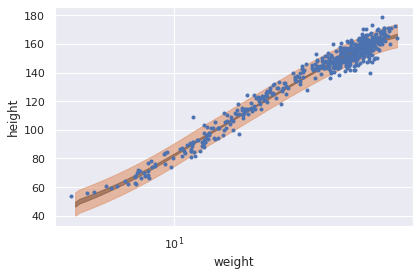

In [18]:
height_pred = pm.fast_sample_posterior_predictive(trace_cube, model=m_cube)["height"]

fig, ax = plt.subplots()
ax.semilogx(kung.weight, kung.height, ".")
az.plot_hdi(kung.weight, trace_cube.μ, ax=ax, color="black")
az.plot_hdi(kung.weight, height_pred, ax=ax)
ax.set(xlabel="weight", ylabel="height")
fig.tight_layout()

In [19]:
trace_cube.α.mean(), trace_cube.β.mean(axis=0)

(138.2609671895298, array([-26.18067804,  17.75363267,  34.99766205]))

## Double bonus, just keep one

In [20]:
weight_cube_root = standardize(kung.weight ** (1 / 3))
with pm.Model() as m_cube_root:
    a = pm.Normal("α", mu=155, sd=20)
    b = pm.Normal("β", mu=0, sd=10)
    mu = pm.Deterministic("μ", a + b * weight_cube_root)
    sigma = pm.Uniform("σ", 0, 50)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=kung.height)
    trace_cube_root = pm.sample()

/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


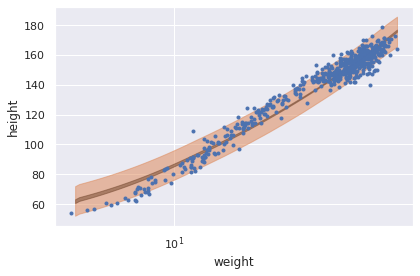

In [21]:
height_pred = pm.fast_sample_posterior_predictive(trace_cube_root, model=m_cube_root)[
    "height"
]

fig, ax = plt.subplots()
ax.semilogx(kung.weight, kung.height, ".")
az.plot_hdi(kung.weight, trace_cube_root.μ, ax=ax, color="black")
az.plot_hdi(kung.weight, height_pred, ax=ax)
ax.set(xlabel="weight", ylabel="height")
fig.tight_layout()

This isn't fit to be a parent. Can't handle babies.

In [22]:
teens = kung[(13 <= kung.age) & (kung.age <= 19)]
teens.head()

,height,weight,age,male,weight_s,log_weight,log_weight_s,log_height
8,147.955,34.869885,19.0,0,-0.050324,3.551624,0.189759,4.996908
23,129.540,23.586784,13.0,1,-0.816882,3.160687,-0.488998,4.863990
27,147.320,35.465224,19.0,0,-0.009878,3.568553,0.219152,4.992607
28,137.160,27.328918,17.0,1,-0.562647,3.307945,-0.233323,4.921148
29,125.730,22.679600,16.0,0,-0.878515,3.121466,-0.557095,4.834137


In [23]:
teens.describe()

,height,weight,age,male,weight_s,log_weight,log_weight_s,log_height
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
mean,141.790711,33.176536,15.950820,0.426230,-0.165368,3.469883,0.047839,4.951368
std,10.964940,8.508303,2.003549,0.498632,0.578042,0.254625,0.442088,0.078197
min,117.983000,20.128145,13.000000,0.000000,-1.051857,3.002119,-0.764308,4.770541
25%,132.715000,25.627948,15.000000,0.000000,-0.678208,3.243683,-0.344896,4.888204
50%,143.510000,31.524644,16.000000,0.000000,-0.277595,3.450770,0.014653,4.966405
75%,147.955000,40.624834,17.000000,1.000000,0.340659,3.704380,0.454979,4.996908
max,162.560000,50.802304,19.000000,1.000000,1.032102,3.927942,0.843135,5.091047


/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


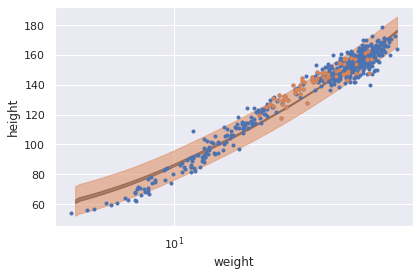

In [24]:
fig, ax = plt.subplots()
ax.semilogx(kung.weight, kung.height, ".")
ax.semilogx(teens.weight, teens.height, ".")
az.plot_hdi(kung.weight, trace_cube_root.μ, ax=ax, color="black")
az.plot_hdi(kung.weight, height_pred, ax=ax)
ax.set(xlabel="weight", ylabel="height")
fig.tight_layout()

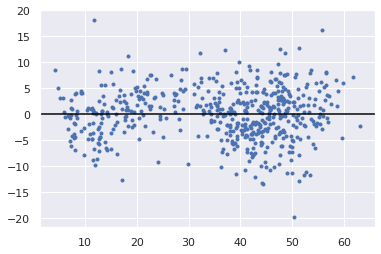

In [25]:
fig, ax = plt.subplots()
ax.plot(kung.weight, kung.height - trace_cube.μ.mean(axis=0), ".")
ax.axhline(0, color="black")

## Bonus 3: log log

In [26]:
with pm.Model() as m_log_log:
    a = pm.Normal("α", mu=5, sd=5)
    b = pm.Normal("β", mu=0, sd=50)
    mu = pm.Deterministic("μ", a + b * kung.log_weight_s)
    sigma = pm.Uniform("σ", 0, 50)
    log_height = pm.Normal("log_height", mu=mu, sd=sigma, observed=kung.log_height)
    trace_log_log = pm.sample()

/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [27]:
trace_log_log.α.mean(), trace_log_log.β.mean(), trace_log_log.σ.mean()

(4.903616281476144, 0.2359138021660716, 0.053065979646034614)

/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


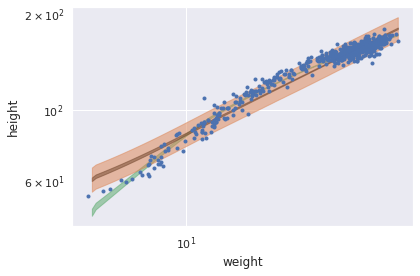

In [28]:
height_pred = pm.fast_sample_posterior_predictive(trace_log_log, model=m_log_log)[
    "log_height"
]

fig, ax = plt.subplots()
ax.loglog(kung.weight, kung.height, ".")
az.plot_hdi(kung.weight, trace_log.μ, ax=ax, color="C2")
az.plot_hdi(kung.weight, np.exp(trace_log_log.μ), ax=ax, color="black")
az.plot_hdi(kung.weight, np.exp(height_pred), ax=ax)
ax.set(xlabel="weight", ylabel="height")
fig.tight_layout()

/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/jnassar/.local/lib/pyenv/versions/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


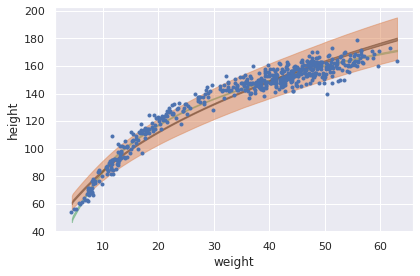

In [29]:
height_pred = pm.fast_sample_posterior_predictive(trace_log_log, model=m_log_log)[
    "log_height"
]

fig, ax = plt.subplots()
ax.plot(kung.weight, kung.height, ".")
az.plot_hdi(kung.weight, trace_log.μ, ax=ax, color="C2")
az.plot_hdi(kung.weight, np.exp(trace_log_log.μ), ax=ax, color="black")
az.plot_hdi(kung.weight, np.exp(height_pred), ax=ax)
ax.set(xlabel="weight", ylabel="height")
fig.tight_layout()

[Text(0.5, 1.0, 'residuals'), Text(0, 0.5, 'height'), Text(0.5, 0, 'weight')]

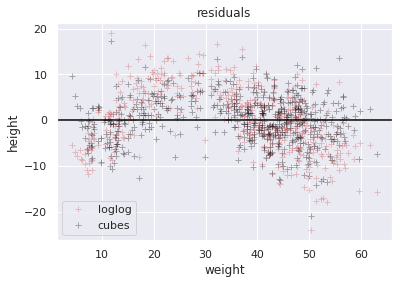

In [30]:
fig, ax = plt.subplots()
ax.plot(
    kung.weight,
    kung.height - np.exp(trace_log_log.μ.mean(axis=0)),
    "+",
    color="C3",
    alpha=0.3,
    label="loglog",
)
ax.plot(
    kung.weight,
    kung.height - trace_log.μ.mean(axis=0),
    "+",
    color="black",
    alpha=0.3,
    label="cubes",
)
ax.legend()
ax.axhline(0, color="black")
ax.set(title="residuals", ylabel="height", xlabel="weight")

[Text(0.5, 1.0, 'residuals'), Text(0, 0.5, 'height'), Text(0.5, 0, 'weight')]

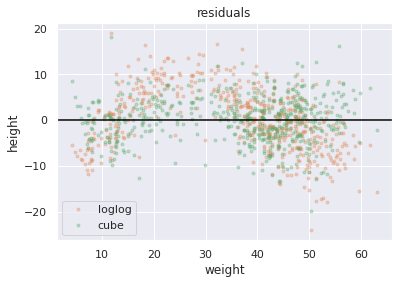

In [31]:
fig, ax = plt.subplots()
ax.plot(
    kung.weight,
    kung.height - np.exp(trace_log_log.μ.mean(axis=0)),
    ".",
    color="C1",
    alpha=0.3,
    label="loglog",
)
ax.plot(
    kung.weight,
    kung.height - trace_cube.μ.mean(axis=0),
    ".",
    color="C2",
    alpha=0.3,
    label="cube",
)
ax.legend()
ax.axhline(0, color="black")
ax.set(title="residuals", ylabel="height", xlabel="weight")